# QLearning for Flappy Bird

The notebook is organized as follows:
1. Functions to save variables in pickle files for RL training
2. Customization of reward/ state format in the gymnasium environment
3. QLearning on discretized space
4. Plot evolution of training scores and rewards
5. Evaluate Policy by choosing the greedy policy that we constructed on new episodes for validation
6. Test Optimized Policy on a few episodes

In [14]:
import optuna
import flappy_bird_gymnasium
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import randint
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import time
import os
import json
import random


In [15]:
import gymnasium as gym
import math
import numpy as np
import pandas as pd
from pathlib import Path

from typing import cast, List, Optional, Sequence, Tuple, Union

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [17]:
from IPython.display import Video
sns.set_context("talk")

## 1. Functions to save variables in pickle files for RL training.

In [18]:
import pickle

# Variable à sauvegarder
data = {"state1": [0.5, 0.7], "state2": [1.0, -0.2]}

# Sauvegarde dans un fichier Pickle
def save_variable_in_pickle(data, name_file):
    with open(name_file, "wb") as f:
        pickle.dump(data, f)

def load_variable_pickel(name_file):
    # Charger les données
    with open(name_file, "rb") as f:
        loaded_data = pickle.load(f)
    return loaded_data

save_variable_in_pickle(data, "QLearning/data/test.pkl")
new_data = load_variable_pickel("QLearning/data/test.pkl")
print("Test pickle")
print(new_data)

Test pickle
{'state1': [0.5, 0.7], 'state2': [1.0, -0.2]}


## 2. Customization of Reward / State fromat in the Gymnasium environment

CUSTOM REWARD in flappy bird gymnasium

In [19]:
class CustomRewardWrapperFlappyBird(gym.Wrapper):
    """custom reward wrapper to change the reward of the gymnasium environement of Flappy Bird
        Before
        +0.1 - every frame it stays alive
        +1.0 - successfully passing a pipe
        -1.0 - dying
        −0.5 - touch the top of the screen
        After
        if reward_extreme=True
        Reward dead : -1000
        Reward alive : 0
        if reward_moderate=True
        Penalty more important for death and reward more important for passing pipes.
    """
    def __init__(self, env, reward_extreme=False, reward_moderate=False):
        super().__init__(env)
        self.reward_extreme = reward_extreme
        self.reward_moderate = reward_moderate


    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        
        # version extreme
        if self.reward_extreme:
            if done:
                reward = -1000
            else: 
                reward = 0

        if self.reward_moderate:
            if reward== 1 :
                reward = 2  # On augmente la récompense des tuyaux
            elif reward == 0.1:
                reward = 0  # Chaque frame survivante reste inchangée
            elif reward == -1.0:
                reward = -5  # Pénalité pour mourir (2 fois et demi plus grave que passer un pipe)
            elif reward == -0.5:
                reward = 0  # Pénalité pour toucher le haut de l'écran
        
        return obs, reward, done, truncated, info
    
env = gym.make("FlappyBird-v0", use_lidar=False, normalize_obs = True)
env = CustomRewardWrapperFlappyBird(env)

CUSTOM OBSERVATION FORMAT in Flappy Bird Environnement

In [20]:
import numpy as np

def extract_state(obs, player_x=0):
    """
    Extracts the variables needed for Q-learning from the observation.
    
    Variables returned:
    - x0: Horizontal distance between player and next lower pipe.
    - y0: Vertical distance from player to bottom of next pipe.
    - vel: Player's vertical speed.
    - y1: Vertical distance between player and next lower pipe.
    
    :param obs: np.array containing environmental observations.
    :param player_x: Player's horizontal position (often 0 if fixed).
    :return: (x0, y0, vel, y1)
    """
    # horizontal distance to next pipe (x0)
    x0 = obs[3] - player_x # next pipe horizontal pos - player horizontal pos

    # Vertical distance to next pipe bottom (y0)
    y0 = obs[9] - obs[5] # player vertical pos - next bottom pipe vertical pos

    # player vertical speed (vel)
    vel = obs[10]  

    # vertical distance to bottom of next pipe (y1)
    y1 = obs[9] - obs[8] # player vertical pos - next next bottom pipe vertical pos

    return x0, y0, vel, y1


In [21]:
class CustomObservationWrapper(gym.ObservationWrapper):
    """
    Wrapper to modify the observation space of Flappy Bird.
    """
    def __init__(self, env, discretize=False, bins=20, simplify_obs=False):
        super().__init__(env)
        self.discretize = discretize  # Discretization flag
        self.bins = bins  # Number of bins for discretization
        self.simplify_obs = simplify_obs

    def observation(self, obs):
        """
        Extracts and discretizes observation space
        """
        # Extraction de 3 valeurs : distance horizontale au prochain pipe, 
        # la distance verticale au haut de next pipe, la distance verticale au bas de next pipe

        new_obs=obs
        
        if self.simplify_obs:
            new_obs = extract_state(obs) # x0, y0, vel, y1

        # Discrétisation pour Q-learning
        if self.discretize:
            new_obs = np.digitize(new_obs, np.linspace(-1, 1, self.bins)) - 1  # Convertir en indices discrets

        return new_obs

# Utilization
env = gym.make("FlappyBird-v0", use_lidar=False)
env = CustomObservationWrapper(env, discretize=True, bins=15, simplify_obs=True)  # Discrétisation activée


Change reward and discretize observation space

In [22]:
# Initialiser l'environnement
def define_discrete_flappy_bird(change_reward=True, bins=25, simplify_obs=False, reward_extreme=True, reward_moderate=False):
    env = gym.make("FlappyBird-v0", use_lidar=False)
    if change_reward:
        env = CustomRewardWrapperFlappyBird(env, reward_extreme=reward_extreme, reward_moderate=reward_moderate) # Reward changée
    env = CustomObservationWrapper(env, discretize=True, bins=bins, simplify_obs=simplify_obs)  # Discrétisation activée
    return env

env = define_discrete_flappy_bird()
print(env.bins, env.simplify_obs)

25 False


Reward change test/observations on one step

In [23]:
env = define_discrete_flappy_bird()
obs, _ = env.reset()

action = env.action_space.sample()

obs, reward, terminated, _, info = env.step(action)

print("Observation:", obs)
print("Reward:", reward)
print("Terminated:", terminated)
print("info", info)
print("score:", info['score'])

env.close()

Observation: [23 15 17 24 12 24 24 12 24 17  2 17]
Reward: 0
Terminated: False
info {'score': 0}
score: 0


## 3. QLearning on discretized space

In [24]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from typing import Dict, Tuple

DISPLAY_EVERY_N_EPISODES = 50

def get_q_values(state, q_table, num_actions):
    """Retourne les Q-values associées à un état sous forme de tuple."""
    state = tuple(state)  # Convertit l'état en tuple pour être utilisé comme clé
    if state not in q_table:
        q_table[state] = [0.0] * num_actions  # Initialisation des Q-values
    return q_table[state]


def epsilon_greedy_policy_q_dict(state, q_table, epsilon, num_actions=2):
    """Choisit une action selon la politique epsilon-greedy."""
    state = tuple(state)  # Convertit en tuple
    if np.random.rand() < epsilon:
        action = np.random.randint(num_actions)  # Exploration entre 0 et 1
    else:
        action = np.argmax(get_q_values(state, q_table, num_actions))  # Exploitation
    return action

def greedy_policy_q_dict(state, q_table, num_actions=2):
    """Choisit l'action avec la meilleure Q-value (greedy policy)."""
    state = tuple(state)  # Convertit en tuple
    return np.argmax(get_q_values(state, q_table, num_actions))

def q_learning(
    environment: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon: float = 0.5,
    num_episodes: int = 60000,
) -> Dict:
    """
    Q-learning avec une Q-table stockée dans un dictionnaire (sans sauvegarde de fichier).
    """
    q_table = {}  # Dictionnaire pour stocker les Q-values
    num_actions = environment.action_space.n  # Nombre d'actions possibles
    history_score=[]
    history_reward=[]

    for episode_index in tqdm(range(1, num_episodes + 1)):
        obs, _ = environment.reset()
        state = tuple(obs)  # Convertir l'observation en tuple (clé du dictionnaire)
        terminated = False
        cumulated_reward = 0

        while not terminated:
            # Politique epsilon-greedy
            action = epsilon_greedy_policy_q_dict(state, q_table, epsilon, num_actions)

            # Prendre une action
            obs_prime, reward, terminated, _, info = environment.step(action)
            next_state = tuple(obs_prime)  # Convertir en clé

            # Récupérer les Q-values
            q_values = get_q_values(state, q_table, num_actions)
            next_q_values = get_q_values(next_state, q_table, num_actions)  # Assure que l'état existe

            # Mise à jour de la Q-table (règle de Q-learning)
            q_values[action] += alpha * (reward + gamma * max(next_q_values) - q_values[action])

            # Mise à jour de l'état actuel
            state = next_state

            cumulated_reward += reward
        
        if episode_index % (num_episodes // 10) == 0:
            last_10_percent_scores = history_score[-(num_episodes // 10):]  # Prend les derniers 10% des scores
            print(f"Épisode {episode_index}/{num_episodes} - Moyenne cumulée {np.mean(history_score)} - Moyenne des derniers 10% : {np.mean(last_10_percent_scores)}")

        history_score.append(info['score'])
        history_reward.append(cumulated_reward)
        
        # Réduction progressive de epsilon
        epsilon = max(0.01, epsilon * 0.995)  # Diminue progressivement epsilon mais reste ≥ 0.01

    return history_score, history_reward, q_table


### Choose parameters to run QLearning on Flappy Bird:
- reward
- state format
- number of training episodes

In [25]:
# Parameters to choose

# Rewards
change_reward = True
reward_extreme= True
reward_moderate=False

# Observations/state format
simplify_obs=False

# Create the env
env = define_discrete_flappy_bird(change_reward=change_reward, bins = 25, simplify_obs=simplify_obs, reward_extreme=reward_extreme, reward_moderate=reward_moderate)

# Choose number of training episodes
# num_ep= 50000 implies 2mn training but for real training, set the bar higher.
# num_ep = 100000 implies 8mn training
# num_ep = 200000 implies 13mn training
num_ep = 100000 # for real training, take more episodes (like 300000) and here is an idea of time: 300000 in 20mn, 500000 in 40mn
history_score, history_reward, q_table = q_learning(env, num_episodes=num_ep) # 700000

# Save the q_table and the training score evolution in pickle files
save_variable_in_pickle(history_score, f"data/history_score_reward_extreme_{reward_extreme}_bins_25_obs_original_{not simplify_obs}_ep{num_ep}.pkl")
save_variable_in_pickle(q_table, f"data/q_table_extreme_reward_ep{num_ep}_obs_original.pkl")
save_variable_in_pickle(q_table, f"data/history_reward_extreme_ep{num_ep}_obs_original.pkl")

  0%|          | 345/100000 [00:00<01:48, 920.32it/s]


KeyboardInterrupt: 

## 4. Plots evolution of training scores and rewards

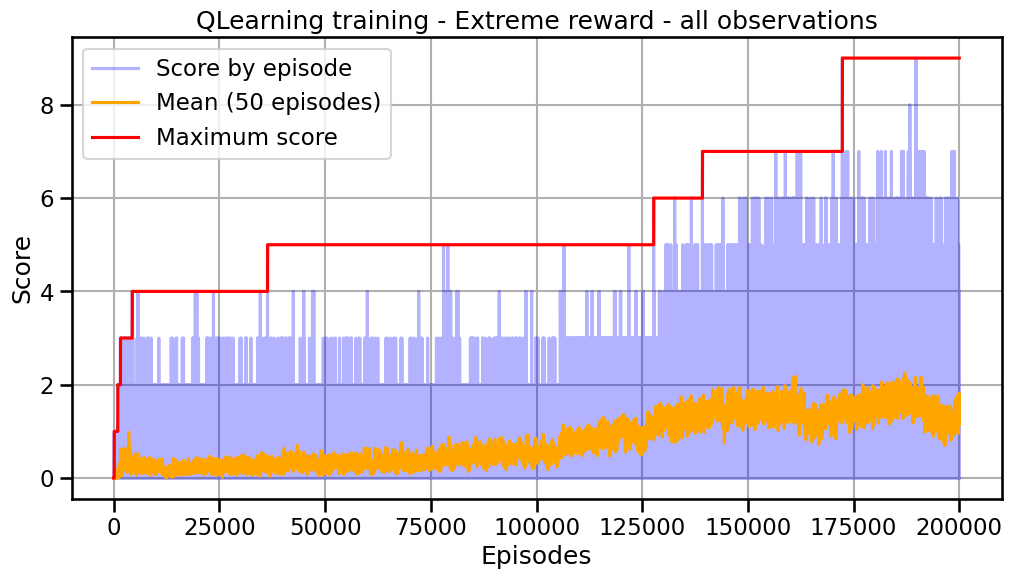

In [ ]:
def plot_history_score(history_score, window=50, title="Flappy Bird - Simplified game - Evolution of scores with training"):
    """
    Affiche l'évolution des scores au fil des épisodes en RL.
    
    - Trace les scores de chaque épisode.
    - Affiche une moyenne pondérée des scores (moyenne glissante).
    - Indique le score maximal atteint à chaque épisode.
    
    :param history_score: Liste des scores obtenus à chaque épisode.
    :param window: Taille de la fenêtre pour la moyenne glissante.
    """
    num_episodes = len(history_score)
    episodes = np.arange(1, num_episodes + 1)

    avg_scores = np.convolve(history_score, np.ones(window)/window, mode='valid')

    max_scores = np.maximum.accumulate(history_score)

    plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=episodes, y=history_score, label="Score by episode", alpha=0.3, color='blue')

    sns.lineplot(x=episodes[window-1:], y=avg_scores, label=f"Mean ({window} episodes)", color='orange')

    # Tracer le maximum des scores atteints
    sns.lineplot(x=episodes, y=max_scores, label="Maximum score", color='red')

    # Labels et titre
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation avec des scores simulés
plot_history_score(history_score, title="QLearning training - Extreme reward - all observations")


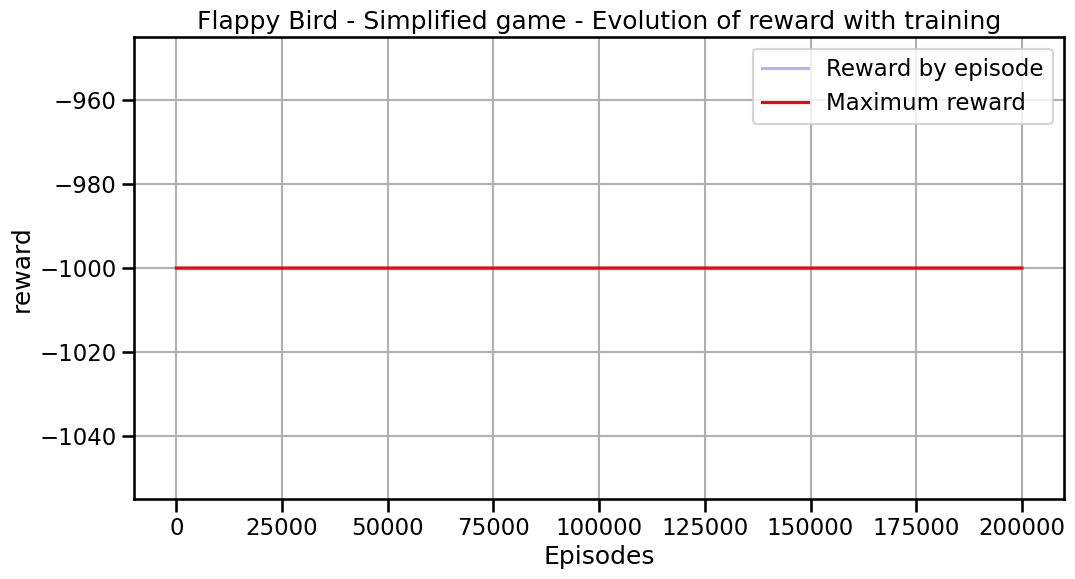

In [ ]:
def plot_history_reward(history_reward, window=50, title="Flappy Bird - Simplified game - Evolution of reward with training"):
    """
    Affiche l'évolution des reward au fil des épisodes en RL.

    :param history_reward: Liste des reward obtenus à chaque épisode.
    :param window: Taille de la fenêtre pour la moyenne glissante.
    """
    num_episodes = len(history_reward)
    episodes = np.arange(1, num_episodes + 1)

    avg_reward = np.convolve(history_reward, np.ones(window)/window, mode='valid')

    max_reward = np.maximum.accumulate(history_reward)

    plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=episodes, y=history_reward, label="Reward by episode", alpha=0.3, color='blue')

    #sns.lineplot(x=episodes[window-1:], y=avg_reward, label=f"Mean ({window} episodes)", color='orange')

    sns.lineplot(x=episodes, y=max_reward, label="Maximum reward", color='red')

    # Labels et titre
    plt.xlabel("Episodes")
    plt.ylabel("reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history_reward(history_reward)

If we used extreme rewards, we only have reward=-1000 for all episodes because the cumulative reward is 0 until the death of the bird which costs -1000.

## 5. Evaluate Policy by choosing the greedy policy that we constructed on new episodes for validation

Average reward: -1000.0
Average score: 1.876


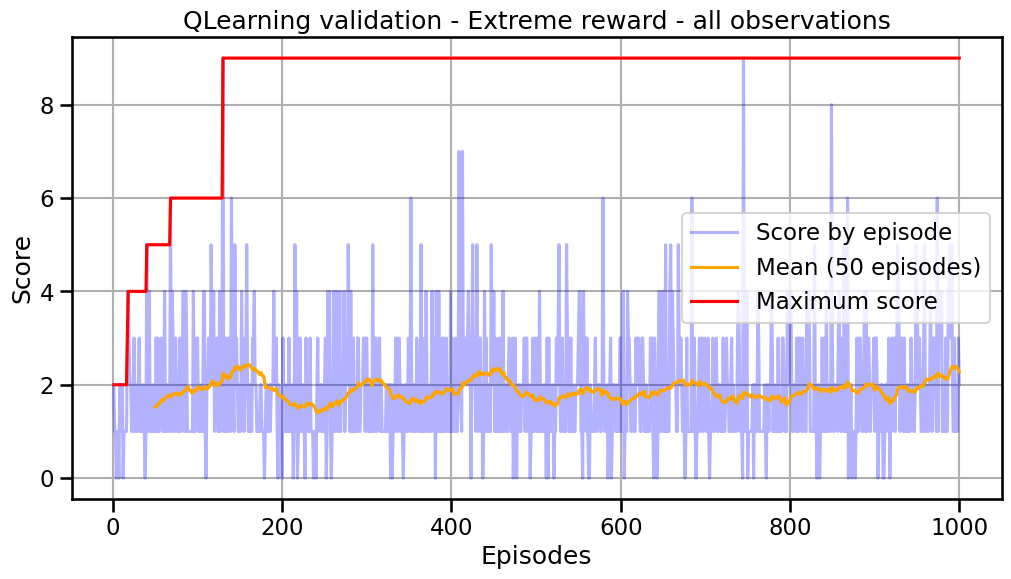

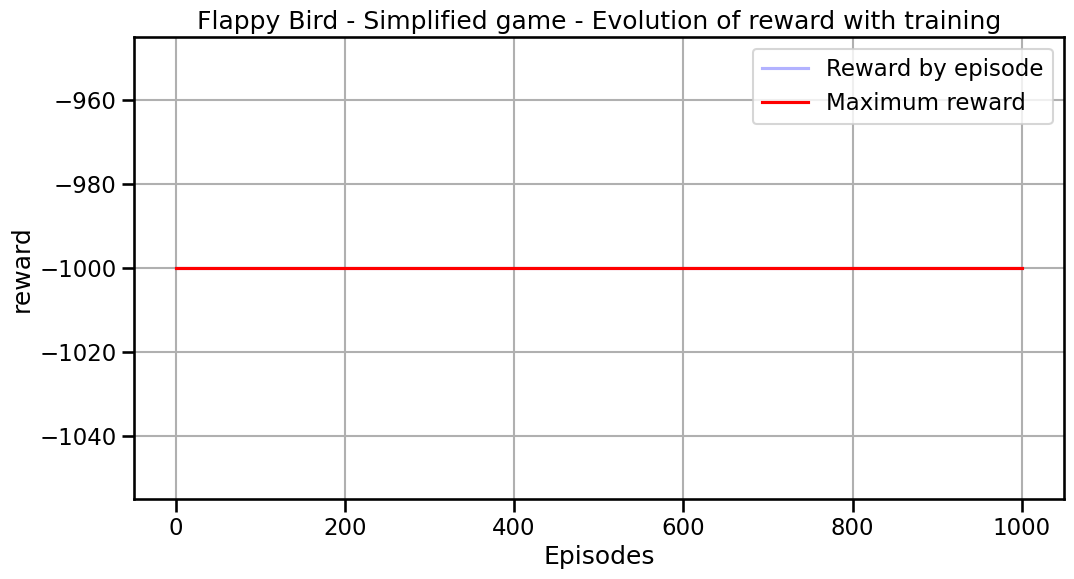

In [ ]:
environment = define_discrete_flappy_bird(change_reward=change_reward, bins = 25, simplify_obs=simplify_obs, reward_extreme=reward_extreme, reward_moderate=reward_moderate)

reward_list = []
score_list=[]
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()
    episode_over = False
    cumulated_reward=0

    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy_q_dict(state, q_table)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated
        cumulated_reward+=reward

    reward_list.append(cumulated_reward)
    score_list.append(info['score'])

reward_df = pd.DataFrame(reward_list)
score_df = pd.DataFrame(score_list)

print(
    'Average reward:',
    np.average(reward_df),
)
print(
    'Average score:',
    np.average(score_df),
)
environment.close()

plot_history_score(score_list, title="QLearning validation - Extreme reward - all observations")
plot_history_reward(reward_list)


## 6. Test Optimized Policy on a few episodes

In [ ]:
NUM_EPISODES = 7

environment = define_discrete_flappy_bird(change_reward=change_reward, bins = 25, simplify_obs=simplify_obs, reward_extreme=reward_extreme, reward_moderate=reward_moderate)

environment = gym.wrappers.RecordEpisodeStatistics(environment, buffer_length=NUM_EPISODES)

score_list=[]

for episode_index in range(NUM_EPISODES):
    state, info = environment.reset()

    episode_over = False
    while not episode_over:
        # action = epsilon_greedy_policy(state, q_array_ex3, epsilon)
        action = greedy_policy_q_dict(state, q_table)
        state, reward, terminated, truncated, info = environment.step(action)
        episode_over = terminated or truncated

    reward_list.append(reward)
    #print(info)
    score_list.append(info['score'])

print(f'Episode time taken: {environment.time_queue}')
print(f'Episode total rewards: {environment.return_queue}')
print(f'Episode lengths: {environment.length_queue}')
print(f"Scores:", score_list)

environment.close()

Episode time taken: deque([0.006371, 0.003914, 0.001492, 0.006454, 0.00652, 0.006469, 0.003137], maxlen=7)
Episode total rewards: deque([-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0], maxlen=7)
Episode lengths: deque([122, 122, 63, 181, 202, 199, 122], maxlen=7)
Scores: [2, 2, 1, 4, 4, 4, 2]
